# Processing Google Ngrams Fre 2020 version 

The downloading follows the same script as for the 2012 version. See `Desktop/mcf/recherche/lipn/articles-ec-2013-/Sherbrooke_2019/hautdegre/bin/retrieve_googlengrams.fr.2020.sh`.
The initial filtering is limited to check the existence of the prefix (we could have added a filter on POS tags, but its is done in the next cell).

The main difference is the file format : whereas in the 2012 version, each line contains the `ngram TAB year TAB total_count TAB total_books NEWLINE`, the 2020 version follows a variable length tabulated version :
`ngram TAB year1,total_count1,total_books1 TAB year2,total_count2,total_books2 ... TAB yearN,total_countN,total_booksN NEWLINE`

Accordingly, the next cell processes each line and  generate a csv version equivalent to the 2012 version. Then the processes are the same.


In [64]:
# read the .cleaned.csv files and extract lines beginning with prefixes within the timespan. Save the results in cleaned.csv.csv


import requests
import sys, csv,re, random, glob,os
import gzip
import pandas as pd


def filter_data(filename, mindate=1899, daterange="1899-2009",query='.+', save=True):
    fout = open(filename+ '.csv', mode="w", encoding="utf-8")
    with open(filename, mode="r", encoding="utf-8") as fin:
        for line in fin:
            if re.search(query, line, re.I) and not(re.search(r"_", line)):
                data= line.strip().split("\t")
                #print(data[0:2])
                if len(data)>1:
                    for yeardata in data[1:]:
                        if re.search(r"^(18|19|20)[0-9]{2}",yeardata) and not(re.search(r'[^\w\s-]',data[0])):
                            if re.search(r",", data[0]):
                                fout.write('"' + data[0].lower().replace('"','\"') + '",' +  yeardata + "\n")
                            else:
                                fout.write(data[0].lower() + ',' +  yeardata + "\n")
                                
    fout.close()


files = glob.glob("../data_ngrams/gngrams.fr.2020.cleaned/*.cleaned.csv")
# main 
prefixes = ('archi','extra','hyper','hypra','maxi','méga','super','ultra')
mindate = 1799
maxdate = 2009
query =  '^(ultra|super|hyper|hypra|extra|méga|archi|maxi|supra).+(18|19|20)[0-9]{2}'

for f in files:
    print("parsing " +  f )
    filter_data(f,mindate=1799,daterange=str_range, query=query)
print("All is done. Now you can parse data the same way as the 2012 version")

parsing ../data_ngrams/gngrams.fr.2020.cleaned/1-00000-of-00006.gz.cleaned.csv
parsing ../data_ngrams/gngrams.fr.2020.cleaned/1-00001-of-00006.gz.cleaned.csv
parsing ../data_ngrams/gngrams.fr.2020.cleaned/1-00002-of-00006.gz.cleaned.csv
parsing ../data_ngrams/gngrams.fr.2020.cleaned/1-00003-of-00006.gz.cleaned.csv
parsing ../data_ngrams/gngrams.fr.2020.cleaned/1-00004-of-00006.gz.cleaned.csv
parsing ../data_ngrams/gngrams.fr.2020.cleaned/1-00005-of-00006.gz.cleaned.csv
parsing ../data_ngrams/gngrams.fr.2020.cleaned/2-00011-of-00115.gz.cleaned.csv
parsing ../data_ngrams/gngrams.fr.2020.cleaned/2-00017-of-00115.gz.cleaned.csv
parsing ../data_ngrams/gngrams.fr.2020.cleaned/2-00020-of-00115.gz.cleaned.csv
parsing ../data_ngrams/gngrams.fr.2020.cleaned/2-00024-of-00115.gz.cleaned.csv
parsing ../data_ngrams/gngrams.fr.2020.cleaned/2-00031-of-00115.gz.cleaned.csv
parsing ../data_ngrams/gngrams.fr.2020.cleaned/2-00032-of-00115.gz.cleaned.csv
parsing ../data_ngrams/gngrams.fr.2020.cleaned/2-000

In [65]:
import requests
import sys, csv,re, random, glob,os
import gzip
import pandas as pd



def read_google_ngram_to_df(filename, mindate=1799, daterange="1799-2009",query='.+'):
    ''' get google ngrams retrieved cleaned files and store into df
    format : ngram TAB year TAB match_count TAB volume_count NEWLINE
    '''
    data_columns = ['string', 'year', 'total_count','total_doc']   
    df1= pd.read_csv(filename, names = data_columns, usecols=['string', 'year', 'total_count'], sep=',', error_bad_lines=False)
    df1['year'] = pd.to_numeric(df1['year'], errors="coerce")
    # convert string to lower
    df1['string'] = df1.string.str.lower()  
    # convert '\s+--?\s+' to ' - '
    df1['string'] = df1.string.str.replace('\s+--?\s+', ' - ', regex=True)
    print("Initial df : ",df1.shape)
    # keep track of skipped lines to check
    dfbk = df1[(~df1['string'].str.contains(query, case=False)) | (df1.string.str.contains('\d'))]
    dfbk.to_csv(filename + '.skippedLines.csv',index=False)
    # just keep lines with string corresponding to query and without digit and with year > 1799
    df2 = df1[(df1['string'].str.contains(query, case=False)) & (~df1.string.str.contains('\d')) & (df1.year > 1799)]
    print("After string regex check : ", df2.shape)
    
    # merge identical string-year rows
    df3 = df2.groupby(['string','year'])['total_count'].sum().reset_index()
    print("After merging strings : ", df3.shape)

    # pivot the data so as to have years as columns and string (ngram) as row index
    df4 = df3.pivot_table(values='total_count', index='string', columns='year', fill_value=0) # index='string', aggfunc='mean'
    return df4

# main 
prefixes = ('archi','extra','hyper','hypra','maxi','méga','super','ultra')
mindate = 1799
maxdate = 2009
query1gram =  '^(?:ultra|super|hyper|hypra|extra|méga|archi|maxi|supra)\w{3,}'
query2gram =  '^(?:ultra|super|hyper|hypra|extra|méga|archi|maxi|supra)\s\w{3,}'
query3gram =  '^(?:ultra|super|hyper|hypra|extra|méga|archi|maxi|supra)\s+--?\s+\w{3,}'
query_type='prefixes'
lang='fre'
str_range = str(mindate) + "-" + str(maxdate)
input_path = '../data_ngrams/gngrams.fr.2020.cleaned/'
output_path = '../data/'

# read google ngrams files downloaded beforehand and merge them
# 1-grams
files1 = glob.glob(input_path + '1-*.cleaned.csv.csv')
res = []
for f in files1:
    if os.stat(f).st_size > 0:
        print("parsing " +  f )
        df = read_google_ngram_to_df(f,mindate=1799,daterange=str_range, query=query1gram)
        res.append(df)
# merge dataframes
df1 = pd.concat(res)
print("Final df : ",df1.shape)
df1.to_csv( output_path + 'fre.2020.prefixes.1.grams.' + str_range + ".csv")
print("***"*20)

# 2-grams
files2 = glob.glob(input_path + '2-*.cleaned.csv.csv')
res = []
for f in files2:
    if os.stat(f).st_size > 0:
        print("parsing " +f )
        df = read_google_ngram_to_df(f,mindate=1799,daterange=str_range, query=query2gram)
        res.append(df)
# merge dataframes
df1 = pd.concat(res)
print("Final df : ",df1.shape)
df1.to_csv( output_path + 'fre.2020.prefixes.2.grams.' + str_range + ".csv")
print("***"*20)

# 3-grams
files3 = glob.glob(input_path + '3-*.cleaned.csv.csv')
res = []
for f in files3:
    if os.stat(f).st_size > 0:
        print("parsing " + f )
        df = read_google_ngram_to_df(f,mindate=1799,daterange=str_range, query=query3gram)
        res.append(df)
# merge dataframes
df1 = pd.concat(res)
print("Final df : ",df1.shape)
df1.to_csv( output_path + 'fre.2020.prefixes.3.grams.' + str_range + ".csv")


parsing ../data_ngrams/gngrams.fr.2020.cleaned/1-00000-of-00006.gz.cleaned.csv.csv
Initial df :  (118723, 3)
After string regex check :  (101971, 3)
After merging strings :  (84085, 3)
parsing ../data_ngrams/gngrams.fr.2020.cleaned/1-00001-of-00006.gz.cleaned.csv.csv
Initial df :  (87826, 3)
After string regex check :  (77440, 3)
After merging strings :  (58105, 3)
parsing ../data_ngrams/gngrams.fr.2020.cleaned/1-00002-of-00006.gz.cleaned.csv.csv
Initial df :  (145057, 3)
After string regex check :  (123708, 3)
After merging strings :  (101126, 3)
parsing ../data_ngrams/gngrams.fr.2020.cleaned/1-00003-of-00006.gz.cleaned.csv.csv
Initial df :  (160741, 3)
After string regex check :  (145227, 3)
After merging strings :  (142711, 3)
parsing ../data_ngrams/gngrams.fr.2020.cleaned/1-00004-of-00006.gz.cleaned.csv.csv
Initial df :  (470192, 3)
After string regex check :  (436236, 3)
After merging strings :  (431369, 3)
parsing ../data_ngrams/gngrams.fr.2020.cleaned/1-00005-of-00006.gz.cleaned

In [66]:
# load stopwords
import re
stoplist={}
stoplist_loc={}
stoplist_all={}
files = glob.glob("../data/stoplists/*.txt")
for file in files:
    with open(file, mode="r",encoding="utf8") as f:
        if re.search(r'stoplist_latinloc', file):
            for line in f:
                if len(line.strip())>0:
                    # tranformation stoplist sans pos-tags
                    line2 = re.sub(r'_[A-Z]+','',line.strip())
                    stoplist_loc[line2]=1
                    stoplist_all[line2]=1
                    
        else:
            for line in f:
                if len(line.strip())>0:
                    # tranformation stoplist sans pos-tags
                    line2 = re.sub(r'_[A-Z]+','',line.strip())
                    stoplist[line2]=1
                    stoplist_all[line2]=1

stop_len = len(stoplist)
stop2_len = len(stoplist_loc)
stop3_len = len(stoplist_all)


stoplist1gram = [w for w in stoplist_all.keys() if not(re.search(r" ", w))]
stoplist2gram = [w for w in stoplist_all.keys() if re.search(r"^[^ ]+ [^ ]+$", w)]
stoplist3gram = [w for w in stoplist_all.keys() if re.search(r"-", w)]

print("Stoplist chargée : " + str(stop_len) + " mots.")
print("Stoplist Loc chargée : " + str(stop2_len) + " mots.")
print("Stoplist complète chargée : " + str(stop3_len) + " mots.")
print("Stoplist 1gram chargée : " + str(len(stoplist1gram)) + " mots.")
print("Stoplist 2gram chargée : " + str(len(stoplist2gram)) + " mots.")
print("Stoplist 3gram chargée : " + str(len(stoplist3gram)) + " mots.")

# sauvegarde des données complètes
fout = open("../data/stoplists/all_stopwords.csv", mode="w", encoding="utf-8")
fout.write("\n".join(stoplist.keys()))
fout.write("\n".join(stoplist_loc.keys()))
fout.close()


Stoplist chargée : 4080 mots.
Stoplist Loc chargée : 665 mots.
Stoplist complète chargée : 4591 mots.
Stoplist 1gram chargée : 3316 mots.
Stoplist 2gram chargée : 1246 mots.
Stoplist 3gram chargée : 29 mots.


# 1-grams Processing

In [67]:

if os.path.isfile('../data/fre.2020.prefixes.1.grams.1799-2009.csv'):
    print("Loading the 1 gram big file (no pos)...")
    df= pd.read_csv('../data/fre.2020.prefixes.1.grams.1799-2009.csv', header=0, sep=',', error_bad_lines=True)#, index_col=0 
else:
    print("Please generate fre.2020.prefixes.1.grams.1799-2009.csv with previous cells")
    exit()
print(df.info())
# élimination stoplist
df = df[~df.string.isin(stoplist)] # elimination mots dans les stoplists
print(df.info())
# generate prefix, word and sep columns 
pref_re = '^(ultra|super|hyper|hypra|extra|méga|archi|maxi|supra)(?:.*)$'
pref_re2 = '^(?:ultra|super|hyper|hypra|extra|méga|archi|maxi|supra)(.*)$'
df['prefix'] = df.string.str.extract(pref_re, expand=True)
df['word'] = df.string.str.extract(pref_re2, expand=True)
df['sep'] = 'FUSION'
print(df.info())
#print(df.head())
print(df.info())
print(df.prefix.value_counts())

Loading the 1 gram big file (no pos)...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17598 entries, 0 to 17597
Columns: 221 entries, string to 2019
dtypes: int64(220), object(1)
memory usage: 29.7+ MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 13740 entries, 0 to 17597
Columns: 221 entries, string to 2019
dtypes: int64(220), object(1)
memory usage: 23.3+ MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 13740 entries, 0 to 17597
Columns: 224 entries, string to sep
dtypes: int64(220), object(4)
memory usage: 23.6+ MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 13740 entries, 0 to 17597
Columns: 224 entries, string to sep
dtypes: int64(220), object(4)
memory usage: 23.6+ MB
None
hyper    3793
super    2963
archi    2361
extra    2170
ultra    1062
méga      714
maxi      677
Name: prefix, dtype: int64


In [68]:
columns = df.columns
periods = [elt for elt in columns if re.match("[0-9]{4}", elt)]
df['full_count'] = df.apply(lambda x: x[periods].sum(), axis=1)
df.head()
df.to_csv("./tmp/df_prefixes_1grams.2020.csv")

# 2-grams Processing

In [69]:

if os.path.isfile('../data/fre.2020.prefixes.2.grams.1799-2009.csv'):
    print("Loading the 2 gram big file (no pos)...")
    df2= pd.read_csv('../data/fre.2020.prefixes.2.grams.1799-2009.csv', header=0, sep=',', error_bad_lines=False)#, index_col=0 
else:
    print("Please first generate fre.2020.prefixes.2.grams.1799-2009.csv")
    exit()

print(df2.info())

# élimination stoplist
df2 = df2[~df2.string.isin(stoplist)]
df2.info()
df2.head()

# colonnes préfix et word
pref_re = '^(ultra|super|hyper|hypra|extra|méga|archi|maxi|supra)\s+(?:\w{3,})$'
pref_re2 = '^(?:ultra|super|hyper|hypra|extra|méga|archi|maxi|supra)\s+(\w{3,})$'
df2['prefix'] = df2.string.str.extract(pref_re, expand=True)
df2['word'] = df2.string.str.extract(pref_re2, expand=True)
df2['sep'] = 'ESPACE'
print(df2.info())
print(df2.prefix.value_counts())


Loading the 2 gram big file (no pos)...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6947 entries, 0 to 6946
Columns: 221 entries, string to 2019
dtypes: float64(62), int64(158), object(1)
memory usage: 11.7+ MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 6324 entries, 0 to 6946
Columns: 221 entries, string to 2019
dtypes: float64(62), int64(158), object(1)
memory usage: 10.7+ MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 6324 entries, 0 to 6946
Columns: 224 entries, string to sep
dtypes: float64(62), int64(158), object(4)
memory usage: 10.9+ MB
None
super    3723
extra     988
ultra     913
hyper     548
archi      89
maxi       63
Name: prefix, dtype: int64


In [70]:
columns = df2.columns
periods = [elt for elt in columns if re.match("[0-9]{4}", elt)]
df2['full_count'] = df2.apply(lambda x: x[periods].sum(), axis=1)
df2.head()
df2.to_csv("./tmp/df_prefixes_2grams.2020.csv")

# 3-grams Processing

In [71]:

if os.path.isfile('../data/fre.2020.prefixes.3.grams.1799-2009.csv'):
    print("Loading the 3 gram big file (no pos)...")
    df3= pd.read_csv('../data/fre.2020.prefixes.3.grams.1799-2009.csv', header=0, sep=',', error_bad_lines=False)#, index_col=0 
else:
    print("Please first generate fre.2020.prefixes.3.grams.1799-2009.csv")
    exit()
print(df3.info())
    
# élimination stoplist
df3 = df3[~df3.string.isin(stoplist)]
df3.info()

# colonnes préfix et word
pref_re = '^(ultra|super|hyper|hypra|extra|méga|archi|maxi|supra)\s+(?:--?)\s+(?:.*)$'
pref_re2 = '^(?:ultra|super|hyper|hypra|extra|méga|archi|maxi|supra)\s+(?:--?)\s+(.*)$'
df3['prefix'] = df3.string.str.extract(pref_re, expand=True)
df3['word'] = df3.string.str.extract(pref_re2, expand=True)
df3['sep'] = 'TIRET'
print(df3.info())
print(df3.prefix.value_counts())
#print(df3.head())

Loading the 3 gram big file (no pos)...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4189 entries, 0 to 4188
Columns: 221 entries, string to 2019
dtypes: float64(206), int64(14), object(1)
memory usage: 7.1+ MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 4145 entries, 0 to 4188
Columns: 221 entries, string to 2019
dtypes: float64(206), int64(14), object(1)
memory usage: 7.0+ MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 4145 entries, 0 to 4188
Columns: 224 entries, string to sep
dtypes: float64(206), int64(14), object(4)
memory usage: 7.1+ MB
None
extra    1532
ultra    1378
hyper     603
archi     416
méga      112
super      92
maxi       12
Name: prefix, dtype: int64


In [72]:
columns = df3.columns
periods = [elt for elt in columns if re.match("[0-9]{4}", elt)]
df3['full_count'] = df3.apply(lambda x: x[periods].sum(), axis=1)
df3.head()
df3.to_csv("./tmp/df_prefixes_3grams.2020.csv")

# Generate Merged Dataframes

In [73]:
df4 = pd.concat([df,df2,df3],ignore_index=True)
print(df4.info())
print(df4.prefix.value_counts())
#print(df4.describe())
df4.to_csv("../data/df_googlengrams_all.2020.csv")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24209 entries, 0 to 24208
Columns: 225 entries, string to full_count
dtypes: float64(209), int64(12), object(4)
memory usage: 41.6+ MB
None
super    6778
hyper    4944
extra    4690
ultra    3353
archi    2866
méga      826
maxi      752
Name: prefix, dtype: int64


# Generate Merged Dataframes with Relative Frequency

In [74]:
def load_total_counts(ngrams, start_year, end_year):
    '''
    This function loads the total counts for a given corpus from Google's source data.
    '''
    files = {'1': 'http://storage.googleapis.com/books/ngrams/books/20200217/fre/totalcounts-1',
            '2':'http://storage.googleapis.com/books/ngrams/books/20200217/fre/totalcounts-2',
            '3':'http://storage.googleapis.com/books/ngrams/books/20200217/fre/totalcounts-3'}
    hdr='Mozilla/5.0 (Macintosh; Intel Mac OS X x.y; rv:10.0) Gecko/20100101 Firefox/10.0'
    headers={'User-Agent':hdr}
    total_counts={}
    for nb in ngrams:
        #print(nb)
        resp = requests.get(files[nb],headers=headers)
        print(nb,files[nb], resp.raise_for_status())
        response = resp.text
        #print(response)
        counts = {}
        data = response.split("\t")
        for row in data:
            try:
                year, word_count, _, _ = row.split(',')
                #print(start_year)
                #print(end_year)
                #print(year)
                if int(year) >= start_year and int(year) <= end_year:
                    #print(year)
                    #print(word_count)
                    #total_counts.append(int(word_count))
                    counts[year]=int(word_count)
                    #print(total_counts)
            except ValueError:
                pass
        total_counts[nb]=counts
            
        
    return total_counts

1 http://storage.googleapis.com/books/ngrams/books/20200217/fre/totalcounts-1 None
2 http://storage.googleapis.com/books/ngrams/books/20200217/fre/totalcounts-2 None
3 http://storage.googleapis.com/books/ngrams/books/20200217/fre/totalcounts-3 None


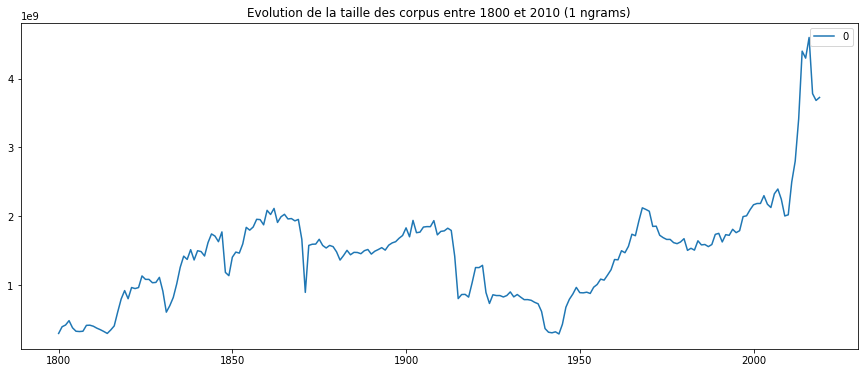

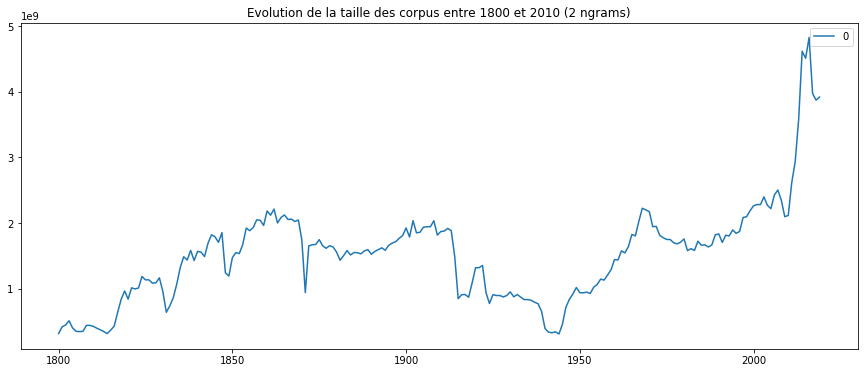

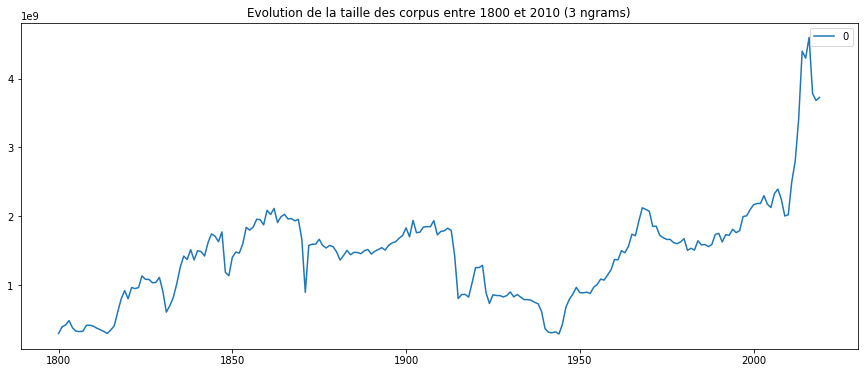

In [75]:
# load totals of tokens per corpus year
totals = load_total_counts(['1','2','3'],1800,2019)
#print(totals)

for k in totals:
    pd.DataFrame.from_dict(totals[k], orient='index').plot(title="Evolution de la taille des corpus entre 1800 et 2010 (" + str(k) + ' ngrams)')
#pdf0.savefig()
#plt.close()


In [88]:
df = df4.copy(deep=True)

df_rel = df.copy(deep=True)
# load totals of tokens per corpus year
totals = load_total_counts(['1'],1800,2019)

# calculate relative frequency for each column

for i in range(1800,2020):
    df_rel[str(i) + '_freqrel'] = (df_rel[str(i)] / totals['1'][str(i)]) * 100000

# remove absolute frequency for df (relative frequency used for clustering and plotting)
df_rel = df_rel.drop([str(i) for i in range(1800,2010)], axis=1)
df_rel.columns = df_rel.columns.str.replace('_freqrel', '')

print(df_rel.info())
df_rel.to_csv("../data/df_googlengrams_all_freqrel.2020.csv", index=False)


1 http://storage.googleapis.com/books/ngrams/books/20200217/fre/totalcounts-1 None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24209 entries, 0 to 24208
Columns: 235 entries, string to 2019
dtypes: float64(230), int64(1), object(4)
memory usage: 43.4+ MB
None


In [89]:
# without outliers

print(df_rel.info())

df_rel2 = df_rel[df_rel.full_count < df_rel.full_count.quantile(0.9)]
print(df_rel2.info())
df_rel2.to_csv("../data/df_googlengrams_all_freqrel.2020.no_outliers.csv", index=False)



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24209 entries, 0 to 24208
Columns: 235 entries, string to 2019
dtypes: float64(230), int64(1), object(4)
memory usage: 43.4+ MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 21785 entries, 0 to 24208
Columns: 235 entries, string to 2019
dtypes: float64(230), int64(1), object(4)
memory usage: 39.2+ MB
None


In [90]:
# for visualization in néoveille
print(df_rel.columns)
periods = [elt for elt in columns if re.match("[0-9]{4}", elt)]
df5 =  df_rel.copy(deep=True)
df5tmp = df5[periods]
df5tmp2 = df5[['string','prefix','word','sep']]
#print(df5tmp.info())
#print(df5tmp2.info())

df6 = df5tmp.merge(df5tmp2, right_index = True, left_index = True)
#print(df6.head())
df7 = df6.melt(id_vars = ['string','prefix','word','sep'], value_name = "rel_freq").dropna()
df7.rename(index=str, columns={"variable": "year"}, inplace=True)
df7 = df7[df7.rel_freq > 0]
print(df7.info())
print(df7.head())
df7.to_csv("../data/df_googlengrams_neoveille.2020.csv", index=False)

Index(['string', '2010', '2011', '2012', '2013', '2014', '2015', '2016',
       '2017', '2018',
       ...
       '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018',
       '2019'],
      dtype='object', length=235)
<class 'pandas.core.frame.DataFrame'>
Index: 1283816 entries, 38 to 5568069
Data columns (total 6 columns):
 #   Column    Non-Null Count    Dtype  
---  ------    --------------    -----  
 0   string    1283816 non-null  object 
 1   prefix    1283816 non-null  object 
 2   word      1283816 non-null  object 
 3   sep       1283816 non-null  object 
 4   year      1283816 non-null  object 
 5   rel_freq  1283816 non-null  float64
dtypes: float64(1), object(5)
memory usage: 68.6+ MB
None
                    string prefix              word     sep  year  rel_freq
38                archibal  archi               bal  FUSION  1800  0.000329
39               archibald  archi              bald  FUSION  1800  0.012822
79         archichancelier  archi        c

In [91]:
# for visualization in néoveille (2010-2019)
print(df_rel.columns)
periods = [elt for elt in columns if re.match("201[0-9]", elt)]
df5 =  df_rel.copy(deep=True)
df5tmp = df5[periods]
df5tmp2 = df5[['string','prefix','word','sep']]
#print(df5tmp.info())
#print(df5tmp2.info())

df6 = df5tmp.merge(df5tmp2, right_index = True, left_index = True)
#print(df6.head())
df7 = df6.melt(id_vars = ['string','prefix','word','sep'], value_name = "rel_freq").dropna()
df7.rename(index=str, columns={"variable": "year"}, inplace=True)
df7 = df7[df7.rel_freq > 0]
print(df7.info())
print(df7.head())
df7.to_csv("../data/df_googlengrams_neoveille.2010-2020.csv", index=False)

Index(['string', '2010', '2011', '2012', '2013', '2014', '2015', '2016',
       '2017', '2018',
       ...
       '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018',
       '2019'],
      dtype='object', length=235)
<class 'pandas.core.frame.DataFrame'>
Index: 219972 entries, 10 to 484179
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   string    219972 non-null  object 
 1   prefix    219972 non-null  object 
 2   word      219972 non-null  object 
 3   sep       219972 non-null  object 
 4   year      219972 non-null  object 
 5   rel_freq  219972 non-null  float64
dtypes: float64(1), object(5)
memory usage: 11.7+ MB
None
        string prefix   word     sep  year  rel_freq
10  archiacina  archi  acina  FUSION  2010       1.0
12   archiacis  archi   acis  FUSION  2010       1.0
22    archiane  archi    ane  FUSION  2010      13.0
28   archiardi  archi   ardi  FUSION  2010       1.0
38    archibal 

In [92]:
# for visualization in néoveille (no outliers)
print(df_rel2.columns)
periods = [elt for elt in columns if re.match("[0-9]{4}", elt)]
df5 =  df_rel2.copy(deep=True)
df5tmp = df5[periods]
df5tmp2 = df5[['string','prefix','word','sep']]
#print(df5tmp.info())
#print(df5tmp2.info())

df6 = df5tmp.merge(df5tmp2, right_index = True, left_index = True)
#print(df6.head())
df7 = df6.melt(id_vars = ['string','prefix','word','sep'], value_name = "rel_freq").dropna()
df7.rename(index=str, columns={"variable": "year"}, inplace=True)
df7 = df7[df7.rel_freq > 0]
print(df7.info())
print(df7.head())
df7.to_csv("../data/df_googlengrams_neoveille.2020.no_outliers.csv", index=False)

Index(['string', '2010', '2011', '2012', '2013', '2014', '2015', '2016',
       '2017', '2018',
       ...
       '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018',
       '2019'],
      dtype='object', length=235)
<class 'pandas.core.frame.DataFrame'>
Index: 971970 entries, 83 to 5010549
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   string    971970 non-null  object 
 1   prefix    971970 non-null  object 
 2   word      971970 non-null  object 
 3   sep       971970 non-null  object 
 4   year      971970 non-null  object 
 5   rel_freq  971970 non-null  float64
dtypes: float64(1), object(5)
memory usage: 51.9+ MB
None
                    string prefix              word     sep  year  rel_freq
83               archiclès  archi              clès  FUSION  1800  0.004603
92   archiconfraternitatis  archi  confraternitatis  FUSION  1800  0.000986
135               archidet  archi               det

In [87]:
# for visualization in néoveille (2010 - 2019 no outliers)
print(df_rel2.columns)
periods = [elt for elt in columns if re.match("201[0-9]", elt)]
df5 =  df_rel2.copy(deep=True)
df5tmp = df5[periods]
df5tmp2 = df5[['string','prefix','word','sep']]
#print(df5tmp.info())
#print(df5tmp2.info())

df6 = df5tmp.merge(df5tmp2, right_index = True, left_index = True)
#print(df6.head())
df7 = df6.melt(id_vars = ['string','prefix','word','sep'], value_name = "rel_freq").dropna()
df7.rename(index=str, columns={"variable": "year"}, inplace=True)
df7 = df7[df7.rel_freq > 0]
print(df7.info())
print(df7.head())
df7.to_csv("../data/df_googlengrams_neoveille.2010-2020.no_outliers.csv", index=False)

Index(['string', '2010', '2011', '2012', '2013', '2014', '2015', '2016',
       '2017', '2018',
       ...
       '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008',
       '2009'],
      dtype='object', length=225)
<class 'pandas.core.frame.DataFrame'>
Index: 88958 entries, 10 to 217849
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   string    88958 non-null  object 
 1   prefix    88958 non-null  object 
 2   word      88958 non-null  object 
 3   sep       88958 non-null  object 
 4   year      88958 non-null  object 
 5   rel_freq  88958 non-null  float64
dtypes: float64(1), object(5)
memory usage: 4.8+ MB
None
         string prefix    word     sep  year  rel_freq
10    archiacis  archi    acis  FUSION  2010       1.0
22    archiardi  archi    ardi  FUSION  2010       1.0
38     archibat  archi     bat  FUSION  2010       4.0
44  archibishop  archi  bishop  FUSION  2010       2.0
47    archibold

# Generate Synthesis on Data

In [93]:
import requests
import sys, csv,re, random, glob,os
import numpy as np                               # vectors and matrices
import pandas as pd                              # tables and data manipulations
import matplotlib.pyplot as plt
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6
import matplotlib
import seaborn as sns                            # more plots
from sklearn.metrics import mean_absolute_error
from matplotlib.backends.backend_pdf import PdfPages

In [94]:
def plot_rolling_simple(df,title, window=10):
    fig, ax = plt.subplots(2,figsize=(20, 10))
    ax[0].plot(df.index, df.data, label='raw data')
    ax[0].plot(df.data.rolling(window=window).mean(),label="rolling mean (window=" + str(window) + ")")
    ax[0].plot(df.data.rolling(window=window).std(), label="rolling std (window=" + str(window) + ")")
    ax[0].legend()

    ax[1].plot(df.index, df.z_data, label="de-trended data")
    ax[1].plot(df.z_data.rolling(window=window).mean(), label="rolling mean (window=" + str(window) + ")")
    ax[1].plot(df.z_data.rolling(window=window).std(), label="rolling std (window=" + str(window) + ")")
    ax[1].legend()

    fig.suptitle(title, fontsize=13)
    plt.tight_layout()
    #fig.autofmt_xdate()
    
# useful for annotating barcharts
def add_value_labels(ax, spacing=5):
    """Add labels to the end of each bar in a bar chart.

    Arguments:
        ax (matplotlib.axes.Axes): The matplotlib object containing the axes
            of the plot to annotate.
        spacing (int): The distance between the labels and the bars.
    """

    # For each bar: Place a label
    for rect in ax.patches:
        # Get X and Y placement of label from rect.
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2

        # Number of points between bar and label. Change to your liking.
        space = spacing
        # Vertical alignment for positive values
        va = 'bottom'

        # If value of bar is negative: Place label below bar
        if y_value < 0:
            # Invert space to place label below
            space *= -1
            # Vertically align label at top
            va = 'top'

        # Use Y value as label and format number with one decimal place
        label = "{:.1f}".format(y_value)

        # Create annotation
        ax.annotate(
            label,                      # Use `label` as label
            (x_value, y_value),         # Place label at end of the bar
            xytext=(0, space),          # Vertically shift label by `space`
            textcoords="offset points", # Interpret `xytext` as offset in points
            ha='center',                # Horizontally center label
            va=va)                      # Vertically align label differently for
                                        # positive and negative values.


            
            
# save dataframe df
# save to excel
def save_report(df, key, outfile):
    """
    Take a report and save it to a single Excel file
    """
    cols = sorted(list(df.columns.values),reverse=True)
    #print(cols)
    writer = pd.ExcelWriter(outfile)
    #for k, grp in df[['prefix','word','full_count','string']].groupby(key):
    for pref in df.prefix.values:
        dfprint = df[df.prefix == pref].groupby(['word','string','sep'])['full_count'].sum().reset_index().sort_values('full_count', ascending=False).set_index(['word'])
        #print(dfprint)
        dfprint.to_excel(writer,pref)
        #grp.sort_values('full_count', ascending=False).set_index(['string','word','sep'])['full_count'].to_excel(writer,k)
    writer.save()
    return True


        count         sum  freq100      prod
prefix                                      
super    6778   5978798.0   3477.0  0.512983
hyper    4944   7022305.0   1995.0  0.403519
extra    4690  21671524.0   2059.0  0.439019
ultra    3353   1928113.0   1631.0  0.486430
archi    2866   4213636.0   1484.0  0.517795
méga      826    800935.0    278.0  0.336562
maxi      752    638167.0    388.0  0.515957


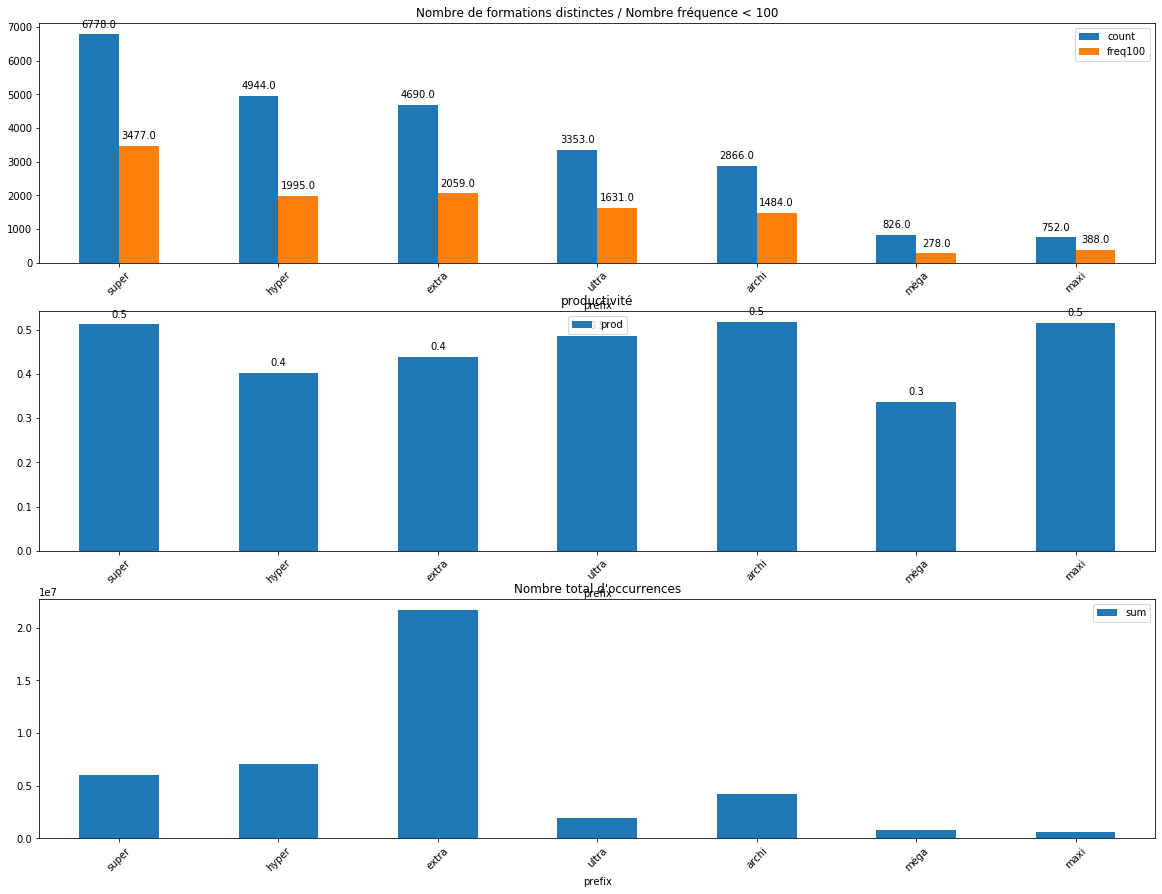

In [95]:
# calcul productivité
def freq100(x):
    #print(x)
    return len(x[x<100])
df2 = df.groupby(['prefix'])['full_count'].agg(['count','sum',freq100]).sort_values('count', ascending=False)

df2['prod'] = df2['freq100'] / df2['count']
print(df2)
fig, ax = plt.subplots(3, figsize=(20, 15))
df2[['count','freq100']].plot(kind="bar", ax=ax[0], rot=45, title="Nombre de formations distinctes / Nombre fréquence < 100",legend=True)
add_value_labels(ax[0])
df2[['prod']].plot(kind="bar",ax=ax[1], rot=45, title="productivité")

df2[['sum']].plot(kind="bar",ax=ax[2], rot=45, title="Nombre total d'occurrences")
add_value_labels(ax[1])


In [80]:
# base for browsing words
words = df.groupby('word')['full_count'].agg(['count','sum']).sort_values('sum', ascending=False)
print(words.head())
words20 = list(words.index.values)[0:20]
print(list(words.index.values)[0:20])

               count         sum
word                            
ordinaire          8  12206395.0
ordinaires         5   5214573.0
ordinairement      4   1202019.0
trophie            4   1060289.0
position           6    939311.0
['ordinaire', 'ordinaires', 'ordinairement', 'trophie', 'position', 'diacre', 'tension', 'ficiellement', 'duchesse', 'posent', 'structure', 'marché', 'ducs', 'prêtre', 'mien', 'marchés', 'tectonique', 'plasie', 'épiscopal', 'chancelier']


        count         sum
prefix                   
super    6778   5978798.0
hyper    4944   7022305.0
extra    4690  21671524.0
ultra    3353   1928113.0
archi    2866   4213636.0
méga      826    800935.0
maxi      752    638167.0
['super' 'hyper' 'extra' 'ultra' 'archi' 'méga' 'maxi']
super
word        aedificati  aequum  aguy  aliments  alliage
1800-12-31    0.000000     0.0   0.0       0.0      0.0
1805-12-31    0.000000     0.0   0.0       0.0      0.0
1810-12-31    0.000000     0.0   0.0       0.0      0.0
1815-12-31    0.000000     0.0   0.0       0.0      0.0
1820-12-31    0.000163     0.0   0.0       0.0      0.0
word        aedificati  aequum  aguy  aliments  alliage
1800-12-31         NaN     NaN   NaN       NaN      NaN
1805-12-31         0.0     0.0   0.0       0.0      0.0
1810-12-31         0.0     0.0   0.0       0.0      0.0
1815-12-31         0.0     0.0   0.0       0.0      0.0
1820-12-31         1.0     0.0   0.0       0.0      0.0
word        aedificati  aequum  

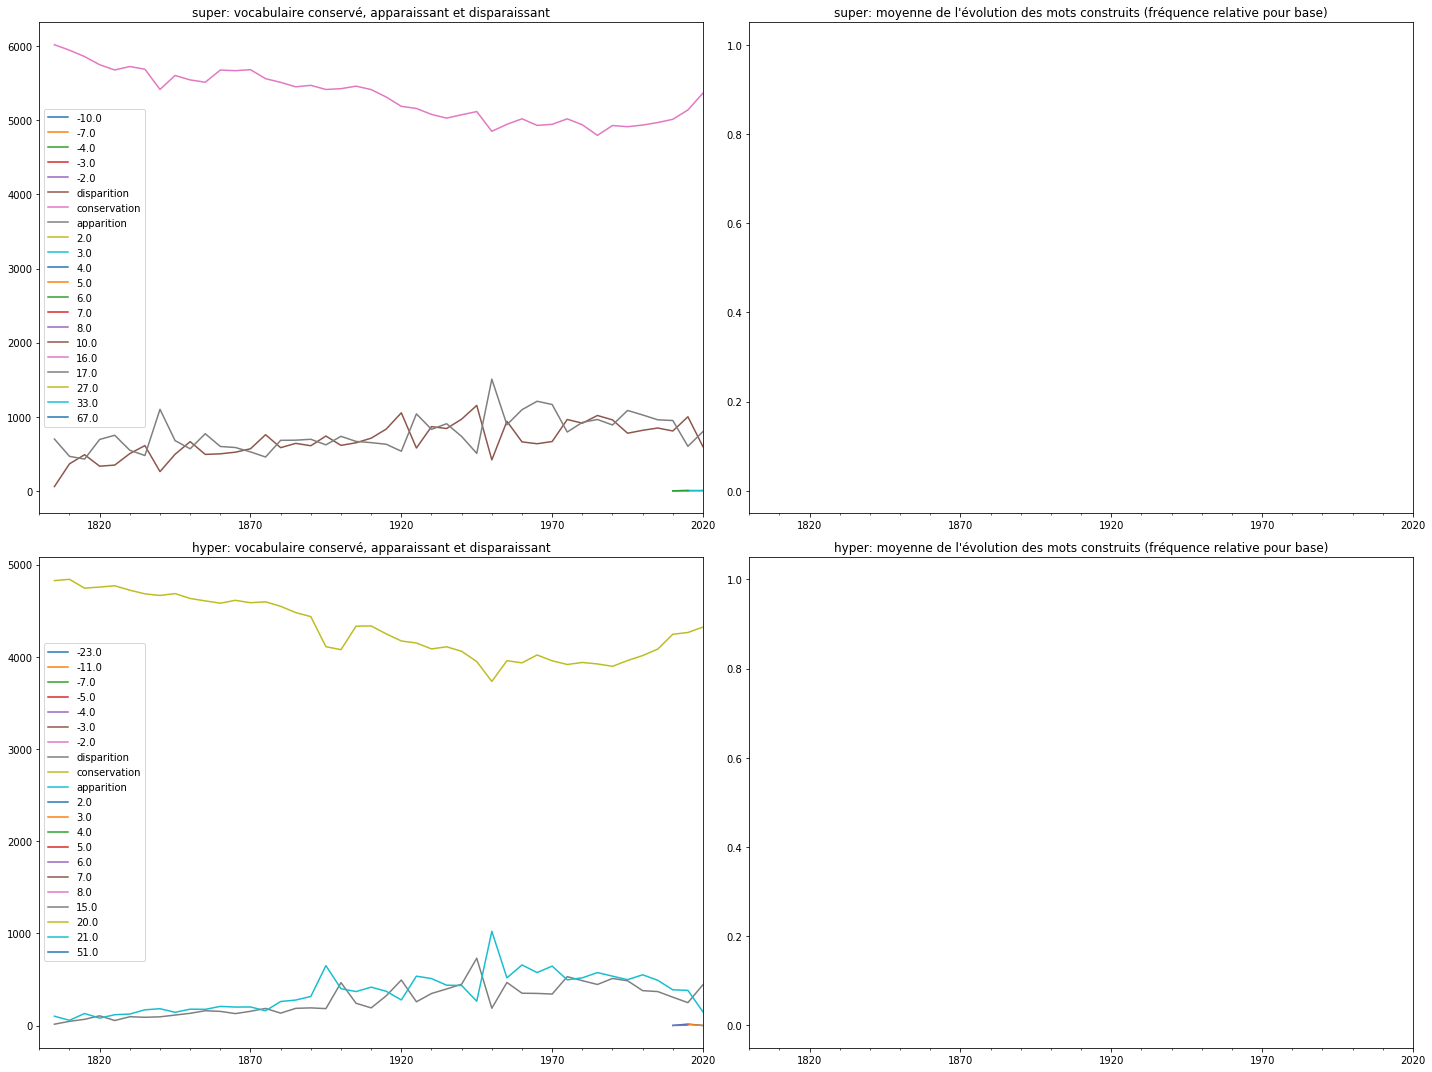

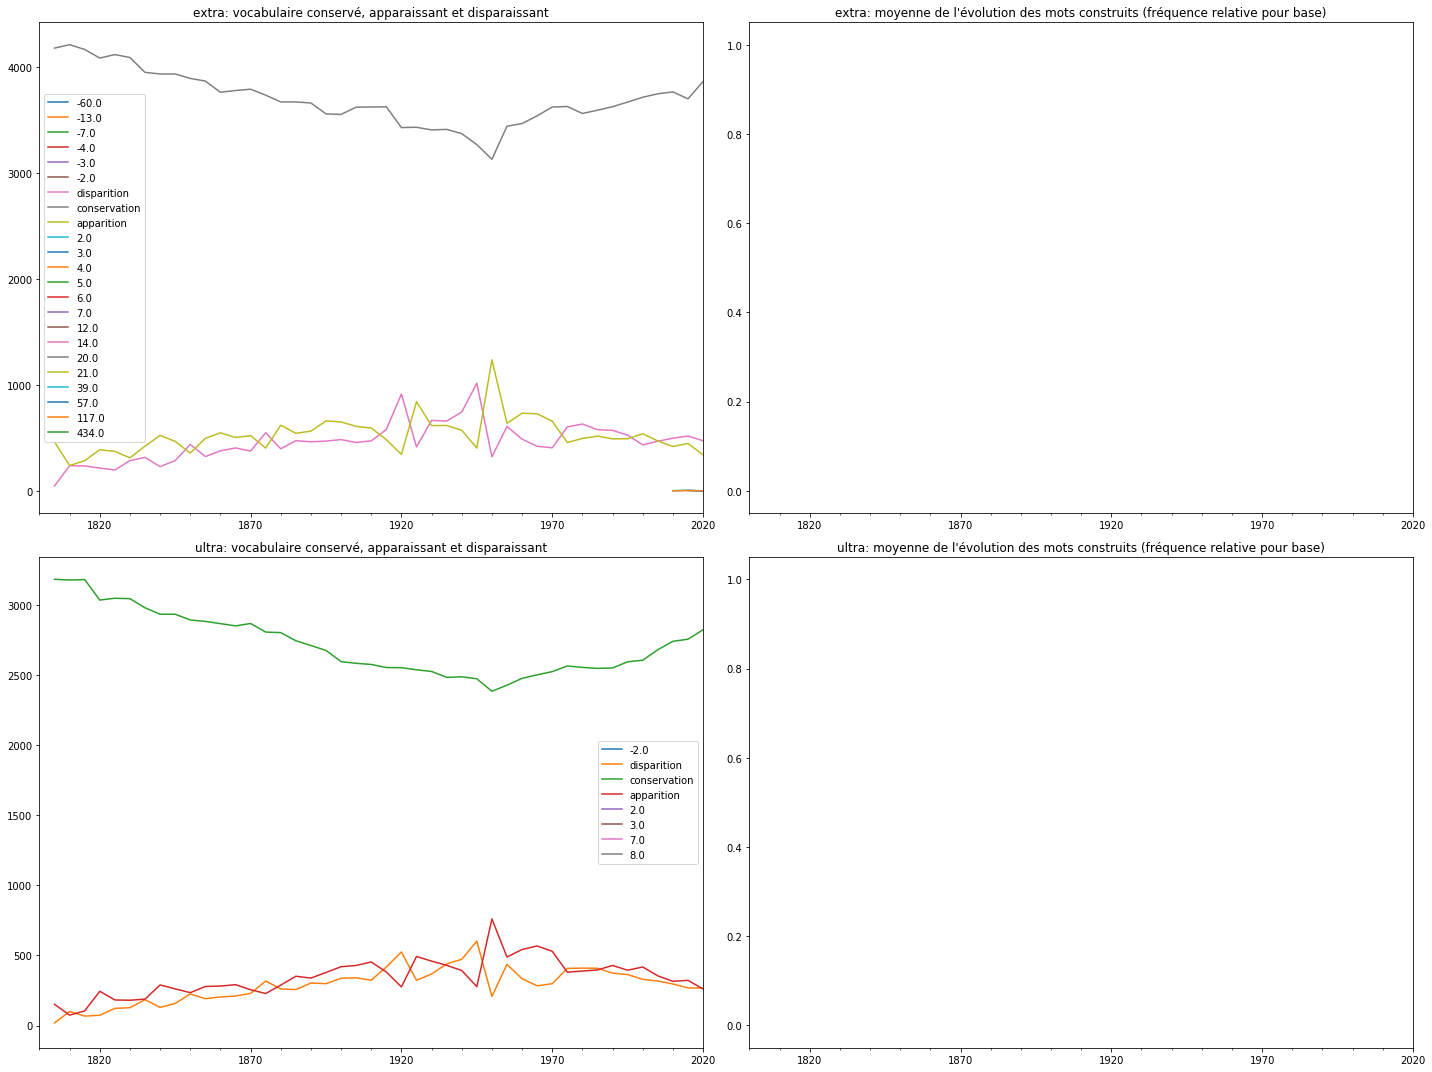

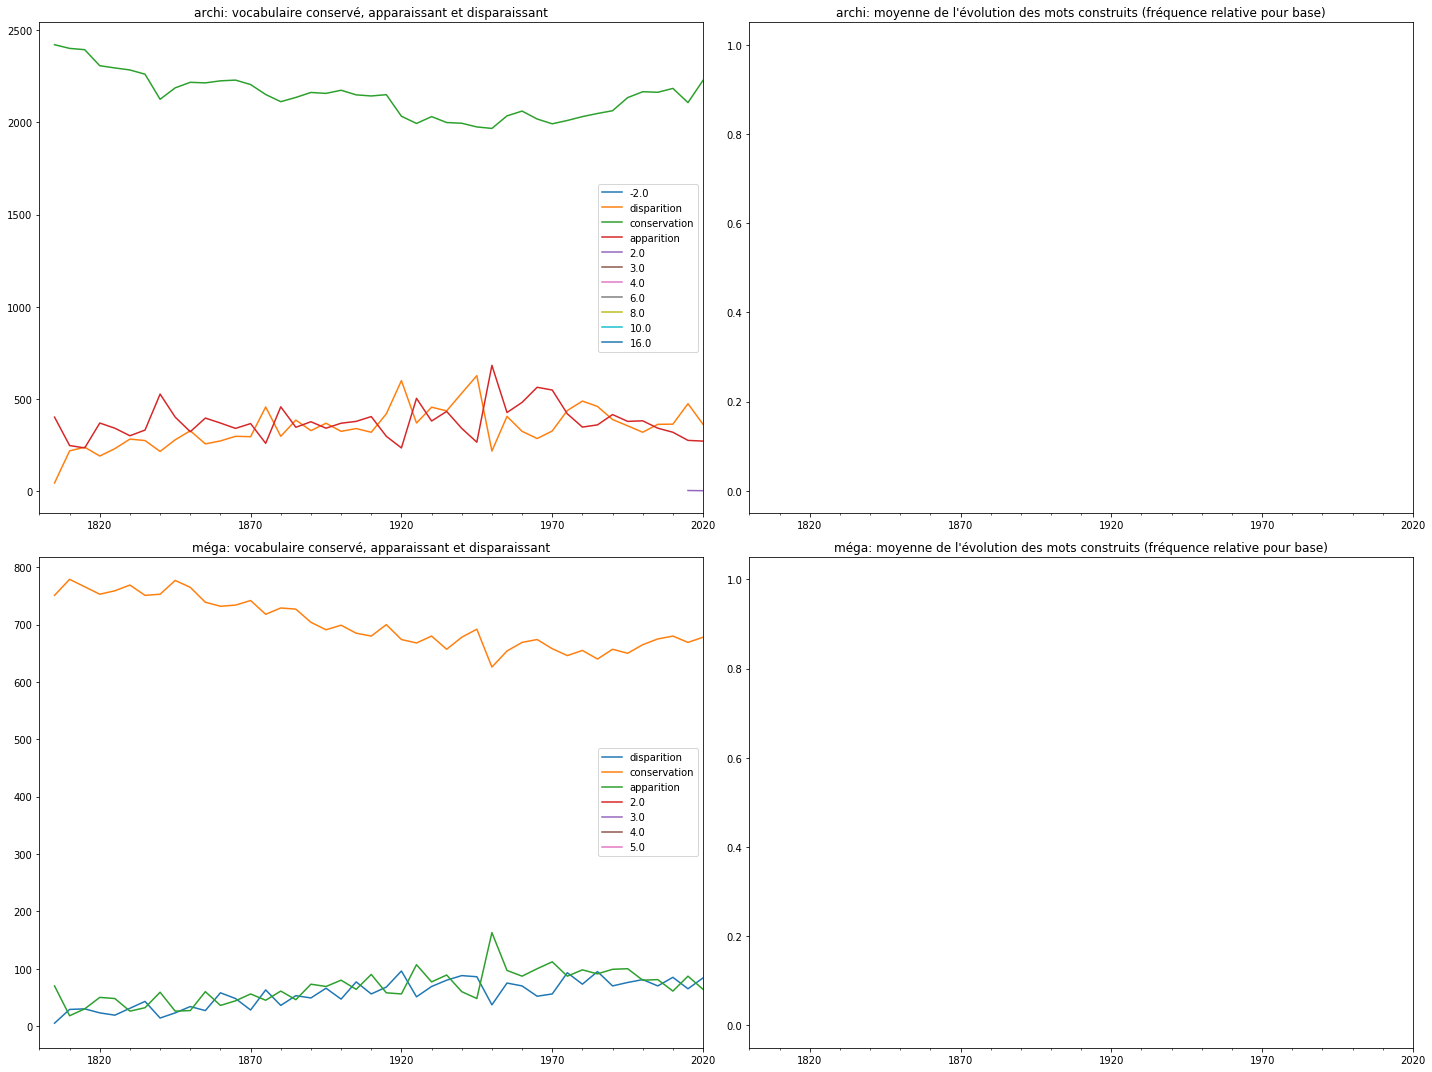

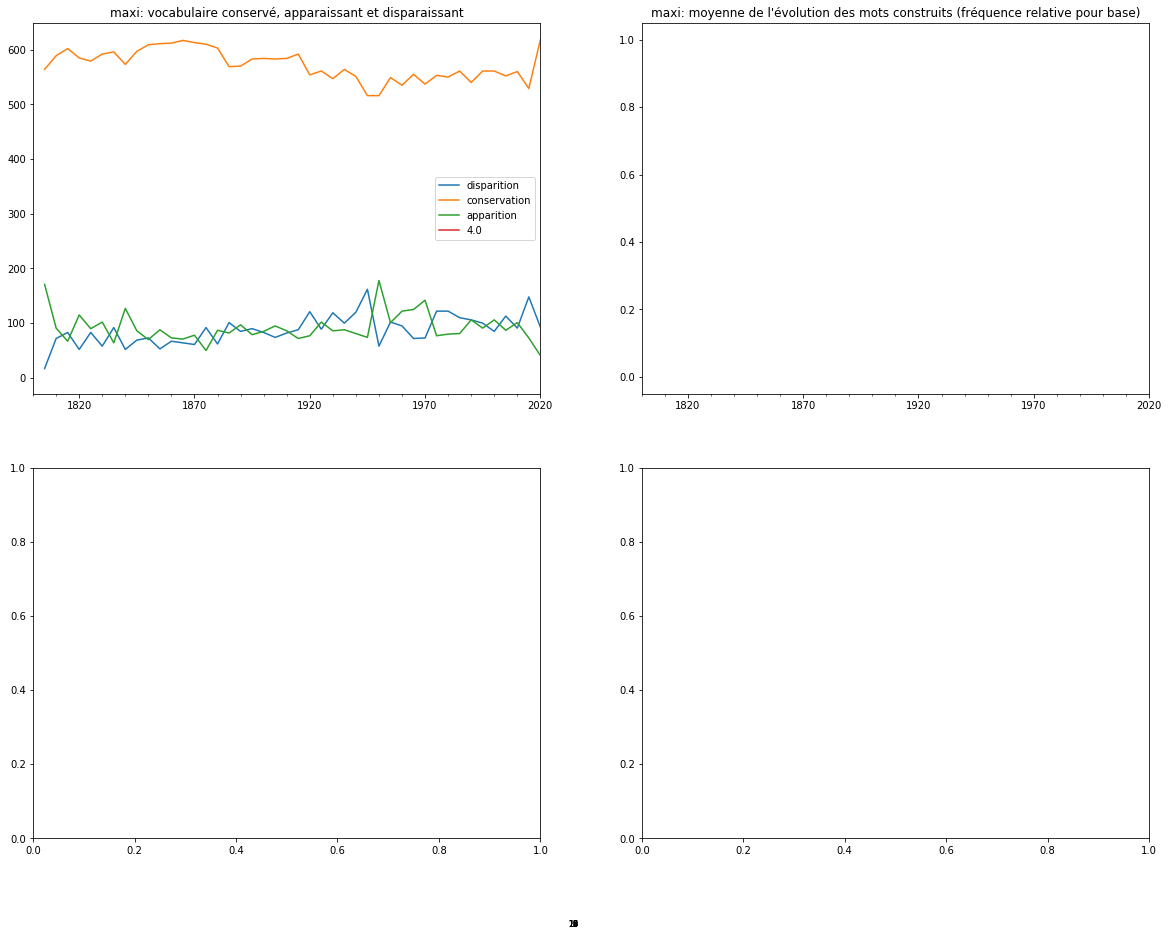

In [81]:
corpus = "googlengrams.2020"
pdf2 = PdfPages('../visu/Prefix_all_synthesis_' + corpus+ '.pdf')

# base for browsing prefixes
dist1 = df.groupby('prefix')['full_count'].agg(['count','sum']).sort_values('count', ascending=False)
print(dist1)
print(dist1.index.values)

#columns = df.columns
#periods = [elt for elt in columns if re.match("[0-9]{4}-[0-9]{2}-[0-9]{2}", elt)]

# distribution entre les prefixes
fig, ax = plt.subplots(2, figsize=(20, 15))
df.groupby('prefix')['full_count'].count().plot(ax=ax[0],kind="bar",title='Distribution des fréquences entre préfixes (nbre de formations distinctes)', rot=45, figsize=(20,10))  # [['full_count']]
add_value_labels(ax[0])
df.groupby('prefix')['full_count'].sum().plot(ax=ax[1],kind="bar",title="Distribution des fréquences entre préfixes (nbre total d'occurrences)", rot=45, figsize=(20,10))  # [['full_count']]
add_value_labels(ax[1])
fig.text(4.25/8.5, 0.5/11., pdf2.get_pagecount(), ha='center', va='center', fontsize=8)
fig.tight_layout()

pdf2.savefig()
plt.close()

# distribution entre les mots
fig, ax = plt.subplots(2, figsize=(20, 15))
#df.groupby('source')['full_count'].nlargest(20).count().plot(ax=ax[0],kind="bar",title='Distribution des fréquences entre sources (nbre de formations distinctes)', rot=45, figsize=(20,10))  # [['full_count']]
df[df.word.isin(words20)].groupby('word')['full_count'].count().plot(ax=ax[0],kind="bar",title='Distribution des fréquences entre mots (20) (nbre de formations distinctes)', rot=45, figsize=(20,10))  # [['full_count']]
add_value_labels(ax[0])
df[df.word.isin(words20)].groupby('word')['full_count'].sum().plot(ax=ax[1],kind="bar",title="Distribution des fréquences entre mots (20) (nbre total d'occurrences)", rot=45, figsize=(20,10))  # [['full_count']]
add_value_labels(ax[1])
fig.text(4.25/8.5, 0.5/11., pdf2.get_pagecount(), ha='center', va='center', fontsize=8)
fig.tight_layout()

pdf2.savefig()
plt.close()

# distribution entre les séparateurs
fig, ax = plt.subplots(2, figsize=(20, 15))
df.groupby('sep')['full_count'].count().plot(ax=ax[0],kind="bar",title='Distribution des fréquences entre séparateurs  (nbre de formations distinctes)', rot=45, figsize=(20,10))  # [['full_count']]
add_value_labels(ax[0])
df.groupby('sep')['full_count'].sum().plot(ax=ax[1],kind="bar",title="Distribution des fréquences entre séparateurs  (nbre total d'occurrences)", rot=45, figsize=(20,10))  # [['full_count']]
add_value_labels(ax[1])
fig.text(4.25/8.5, 0.5/11., pdf2.get_pagecount(), ha='center', va='center', fontsize=8)
fig.tight_layout()

pdf2.savefig()
plt.close()



   
# distribution plots
fig, ax = plt.subplots(8,3, figsize=(20, 15))
# get 0.9 quantile
i = 0
for pref in dist1.index.values:
        dfplot = df[df.prefix == pref]
        sns.distplot(dfplot['full_count'], ax=ax[i][0]).set_title('{} : {} formes distinctes, {} total occurrences (100%)'.format(pref, dist1.loc[pref,'count'], dist1.loc[pref,'sum']))
        # get 0.95 quantile
        q = dfplot["full_count"].quantile(0.9)
        dfplot2 = dfplot[dfplot["full_count"] < q]['full_count']      
        sns.distplot(dfplot2, ax=ax[i][1]).set_title(pref + ' : 90% quantiles')
        #sns.distplot(np.log(dfplot), ax=ax[0])
        sns.boxplot(dfplot2,ax=ax[i][2]).set_title(pref + ' : 90% quantiles')
        i=i+1
fig.text(4.25/8.5, 0.5/11., pdf2.get_pagecount(), ha='center', va='center', fontsize=8)
fig.tight_layout()
pdf2.savefig()
plt.close()         

q = df["full_count"].quantile(0.9)
dfplot2 = df[df["full_count"] < q]      

sns.boxplot(x="prefix", y="full_count", data=dfplot2).set_title("Boîte à moustache des préfixes (fréquences absolues, 90% quantile)")
    # +  (TBD) kind= violin, box, boxen...
pdf2.savefig()
plt.close()


# evolution globale pour chaque préfixe
dfplot = df.groupby('prefix')[periods].sum().T
dfplot.index = pd.to_datetime(dfplot.index)
dfplot_rel = df_rel.groupby('prefix')[periods].sum().T
# freq absolue
fig, ax = plt.subplots(1, figsize=(20, 15))
dfplot.plot(ax=ax,kind="line", title="Evolution des distributions des préfixes (fréquence absolue, périodisation originelle)", rot=45, figsize=(20,10))  # [['full_count']]    
fig.text(4.25/8.5, 0.5/11., pdf2.get_pagecount(), ha='center', va='center', fontsize=8)
pdf2.savefig()
plt.close()


# freq rel
fig, ax = plt.subplots(1, figsize=(20, 15))
dfplot_rel.plot(ax=ax,kind="line", title="Evolution des distributions des préfixes (fréquence relative)", rot=45, figsize=(20,10))  # [['full_count']]    
fig.text(4.25/8.5, 0.5/11., pdf2.get_pagecount(), ha='center', va='center', fontsize=8)
pdf2.savefig()
plt.close()


# freq rel
fig, ax = plt.subplots(1, figsize=(20, 15))
dfplot_rel.ewm(span = 10).mean().plot(ax=ax,kind="line", title="Evolution des distributions des préfixes (fréquence relative), Lissage 10 ans", rot=45, figsize=(20,10))  # [['full_count']]    
fig.text(4.25/8.5, 0.5/11., pdf2.get_pagecount(), ha='center', va='center', fontsize=8)
pdf2.savefig()
plt.close()



# evolution nbre de mots distincts
fig, ax = plt.subplots(1, figsize=(20, 15))
for k,grp in df_rel.groupby(['prefix']):
    grp[periods].astype(bool).sum(axis=0).T.plot(legend=True, ax=ax,kind="line", title="Evolution du nombre de formes différentes", rot=45, figsize=(20,10))  # [['full_count']]
fig.text(4.25/8.5, 0.5/11., pdf2.get_pagecount(), ha='center', va='center', fontsize=8)
pdf2.savefig()
plt.close()


# evolution globale pour chaque mots
fig, ax = plt.subplots(1, figsize=(20, 15))
dfplot = df[df.word.isin(words20)].groupby('word')[periods].sum().T
dfplot.index = pd.to_datetime(dfplot.index)
dfplot_rel = df_rel[df_rel.word.isin(words20)].groupby('word')[periods].sum().T
dfplot4=dfplot.resample('5A').sum()
#dfplot.plot(legend=None, ax=ax[0],kind="line", title="Evolution des distributions des mots (fréquence absolue, périodisation originelle)", rot=45, figsize=(20,10))  # [['full_count']]    
#dfplot4.plot(legend=None, ax=ax[1],kind="line", title="Evolution des distributions des mots (fréquence absolue, période 5 ans)", rot=45, figsize=(20,10))  # [['full_count']]    
dfplot_rel.plot(ax=ax,kind="line", title="Evolution des distributions des mots (fréquence relative)", rot=45, figsize=(20,10))  # [['full_count']]    
fig.text(4.25/8.5, 0.5/11., pdf2.get_pagecount(), ha='center', va='center', fontsize=8)
fig.tight_layout()
pdf2.savefig()
plt.close()


# evolution globale pour chaque séparateur
fig, ax = plt.subplots(1, figsize=(20, 15))
dfplot = df.groupby('sep')[periods].sum().T
dfplot.index = pd.to_datetime(dfplot.index)
dfplot_rel = df_rel.groupby('sep')[periods].sum().T
dfplot4=dfplot.resample('5A').sum()
#dfplot.plot(legend=None, ax=ax[0],kind="line", title="Evolution des distributions des séparateurs (fréquence absolue, périodisation originelle)", rot=45, figsize=(20,10))  # [['full_count']]    
#dfplot4.plot(legend=None, ax=ax[1],kind="line", title="Evolution des distributions des séparateurs (fréquence absolue, période 5 ans)", rot=45, figsize=(20,10))  # [['full_count']]    
dfplot_rel.plot(ax=ax,kind="line", title="Evolution des distributions des séparateurs (fréquence relative)", rot=45, figsize=(20,10))  # [['full_count']]    
fig.text(4.25/8.5, 0.5/11., pdf2.get_pagecount(), ha='center', va='center', fontsize=8)
fig.tight_layout()
pdf2.savefig()
plt.close()




# get 0.9 quantile
i = 0
fig, ax = plt.subplots(2,2, figsize=(20, 15))
for pref in dist1.index.values:
    print(pref)
    dfplot3 = df_rel[df_rel.prefix == pref].set_index('word')[periods].T
    dfplot3.index = pd.to_datetime(dfplot3.index)
    dfplot4=dfplot3.resample('5y').sum()
    print(dfplot4.iloc[0:5,0:5])
    #print(np.log(dfplot4.iloc[0:5,0:5]))
    dfplotdiffres = (dfplot4/1000).apply(np.ceil).diff()
    print(dfplotdiffres.iloc[0:5,0:5])
    dfplotdiffres = dfplotdiffres.loc[:, (dfplotdiffres != 0).any(axis=0)]
    print(dfplotdiffres.iloc[0:5,0:5])
    dfdiffok = dfplotdiffres.apply(lambda x : x.value_counts(), axis=1)
    dfdiffok.rename(columns={-1.0:'disparition',
                          0.0:'conservation',
                          1.0:'apparition'}, 
                 inplace=True)
    print(dfdiffok.iloc[0:5,0:5])
    dfdiffok.plot(ax=ax[i][0], title=pref + ": vocabulaire conservé, apparaissant et disparaissant")

    dfplotdiffres['mean_diff'] = dfplot3.diff().apply(lambda x : x.mean(), axis=1)
    dfplotdiffres['mean_diff'].plot(ax=ax[i][1], title=pref + ": moyenne de l'évolution des mots construits (fréquence relative pour base)")

    if i==1:
        fig.tight_layout()
        pdf2.savefig()
        fig, ax = plt.subplots(2,2, figsize=(20, 15))
        i=0
    else:
        i=i+1
        
 




# moving average, trends etc.
df5 = df_rel.groupby('prefix').sum()[periods]
for pref in dist1.index.values : #df5.index.values:
    series = df5.loc[pref]
    #series.index = series.index.resample("W", how='sum')
    ts = pd.DataFrame({'data':series.values}, index=series.index) # 'year':seriesrel.index, 

    ts['z_data'] = (ts['data'] - ts.data.rolling(window=10).mean()) / ts.data.rolling(window=10).std()
    #ts['zp_data'] = ts['z_data'] - ts['z_data'].shift(10)
    plot_rolling_simple(ts,title= pref, window=10)
    fig.text(4.25/8.5, 0.5/11., pdf2.get_pagecount(), ha='center', va='center', fontsize=8)
    pdf2.savefig()
    plt.close()
pdf2.close()



In [82]:
### par préfixe

for pref in dist1.index.values:
    pdf2 = PdfPages('../visu/' + pref + '_all_synthesis_' + corpus + '.pdf')
    dfpref = df[df.prefix==pref]
    dfwpref = df_rel[df_rel.prefix==pref]
    dfpref_rel = df_rel[df_rel.prefix==pref]

    words = dfpref.groupby('word')['full_count'].agg(['count','sum']).sort_values('sum', ascending=False)
   # print(sources)
    words20pref = list(words.index.values)[0:20]
    #print(list(sources.index.values)[0:20])    

    
    # distribution 
    fig, ax = plt.subplots(2, figsize=(20, 15))
    dfpref.groupby('prefix')['full_count'].count().plot(ax=ax[0],kind="bar",title=pref + ' : distribution des fréquences (nbre de formations distinctes)', rot=45, figsize=(20,10))  # [['full_count']]
    add_value_labels(ax[0])
    dfpref.groupby('prefix')['full_count'].sum().plot(ax=ax[1],kind="bar",title=pref + " : distribution des fréquences (nbre total d'occurrences)", rot=45, figsize=(20,10))  # [['full_count']]
    add_value_labels(ax[1])
    fig.text(4.25/8.5, 0.5/11., pdf2.get_pagecount(), ha='center', va='center', fontsize=8)
    fig.tight_layout()

    pdf2.savefig()
    plt.close()

    
    
    # distribution entre les mots générés les plus fréquents d'informations
    fig, ax = plt.subplots(2, figsize=(20, 15))
    #df.groupby('source')['full_count'].nlargest(20).count().plot(ax=ax[0],kind="bar",title='Distribution des fréquences entre sources (nbre de formations distinctes)', rot=45, figsize=(20,10))  # [['full_count']]
    dfpref[df.word.isin(words20pref)].groupby('word')['full_count'].count().plot(ax=ax[0],kind="bar",title='Distribution des fréquences entre mots (20) (nbre de formations distinctes)', rot=45, figsize=(20,10))  # [['full_count']]
    add_value_labels(ax[0])
    dfpref[df.word.isin(words20pref)].groupby('word')['full_count'].sum().plot(ax=ax[1],kind="bar",title="Distribution des fréquences entre mots (20) (nbre total d'occurrences)", rot=45, figsize=(20,10))  # [['full_count']]
    add_value_labels(ax[1])
    fig.text(4.25/8.5, 0.5/11., pdf2.get_pagecount(), ha='center', va='center', fontsize=8)
    fig.tight_layout()
    
    pdf2.savefig()
    plt.close()
    
    # distribution entre les séparateurs de mots
    fig, ax = plt.subplots(2, figsize=(20, 15))
    #df.groupby('source')['full_count'].nlargest(20).count().plot(ax=ax[0],kind="bar",title='Distribution des fréquences entre sources (nbre de formations distinctes)', rot=45, figsize=(20,10))  # [['full_count']]
    dfpref.groupby('sep')['full_count'].count().plot(ax=ax[0],kind="bar",title='Distribution des fréquences entre séparateurs  (nbre de formations distinctes)', rot=45, figsize=(20,10))  # [['full_count']]
    add_value_labels(ax[0])
    dfpref.groupby('sep')['full_count'].sum().plot(ax=ax[1],kind="bar",title="Distribution des fréquences entre séparateurs  (nbre total d'occurrences)", rot=45, figsize=(20,10))  # [['full_count']]
    add_value_labels(ax[1])
    fig.text(4.25/8.5, 0.5/11., pdf2.get_pagecount(), ha='center', va='center', fontsize=8)
    fig.tight_layout()
    
    pdf2.savefig()
    plt.close()
  
    
    # distribution plots
    fig, ax = plt.subplots(3, figsize=(20, 15))
    dfplot = dfpref
    sns.distplot(dfplot['full_count'], ax=ax[0]).set_title('{} : {} formes distinctes, {} total occurrences (100%)'.format(pref, dist1.loc[pref,'count'], dist1.loc[pref,'sum']))
    # get 0.95 quantile
    q = dfplot["full_count"].quantile(0.9)
    dfplot2 = dfplot[dfplot["full_count"] < q]['full_count']      
    sns.distplot(dfplot2, ax=ax[1]).set_title(pref + ' : 90% quantiles')
    #sns.distplot(np.log(dfplot), ax=ax[0])
    sns.boxplot(dfplot2,ax=ax[2]).set_title(pref + ' : 90% quantiles')
    fig.text(4.25/8.5, 0.5/11., pdf2.get_pagecount(), ha='center', va='center', fontsize=8)
    fig.tight_layout()
    pdf2.savefig()
    plt.close()         
    
    
    
    # evolution globale pour chaque préfixe
    dfplot = dfpref[periods].sum().T
    dfplot.index = pd.to_datetime(dfplot.index)
    dfplot_rel = dfpref_rel[periods].sum().T
    # freq absolue
    fig, ax = plt.subplots(1, figsize=(20, 15))
    dfplot.plot(ax=ax,kind="line", title=pref + " : évolution des distributions des préfixes (fréquence absolue, périodisation originelle)", rot=45, figsize=(20,10))  # [['full_count']]    
    fig.text(4.25/8.5, 0.5/11., pdf2.get_pagecount(), ha='center', va='center', fontsize=8)
    pdf2.savefig()
    plt.close()
    
    
    # freq rel
    fig, ax = plt.subplots(1, figsize=(20, 15))
    dfplot_rel.plot(ax=ax,kind="line", title=pref + " : évolution des distributions des préfixes (fréquence relative)", rot=45, figsize=(20,10))  # [['full_count']]    
    fig.text(4.25/8.5, 0.5/11., pdf2.get_pagecount(), ha='center', va='center', fontsize=8)
    pdf2.savefig()
    plt.close()
    
    # evolution nbre de mots distincts
    fig, ax = plt.subplots(1, figsize=(20, 15))
    dfpref[periods].astype(bool).sum(axis=0).T.plot(ax=ax,kind="line", title=pref + " : évolution du nombre de formes différentes", rot=45, figsize=(20,10))  # [['full_count']]
    fig.text(4.25/8.5, 0.5/11., pdf2.get_pagecount(), ha='center', va='center', fontsize=8)
    pdf2.savefig()
    plt.close()
    
     # evolution globale pour chaque mot
    fig, ax = plt.subplots(1, figsize=(20, 15))
    dfplot = dfpref[dfpref.word.isin(words20pref)].groupby('word')[periods].sum().T
    dfplot.index = pd.to_datetime(dfplot.index)
    dfplot_rel = dfpref_rel[dfpref_rel.word.isin(words20pref)].groupby('word')[periods].sum().T
    dfplot4=dfplot.resample('5A').sum()
#    dfplot.plot(legend=None, ax=ax[0],kind="line", title="Evolution des distributions des mots (fréquence absolue, périodisation originelle)", rot=45, figsize=(20,10))  # [['full_count']]    
#    dfplot4.plot(legend=None, ax=ax[1],kind="line", title="Evolution des distributions des mots (fréquence absolue, période 5 ans)", rot=45, figsize=(20,10))  # [['full_count']]    
    dfplot_rel.plot(ax=ax,kind="line", title=pref + " : évolution des distributions des mots (fréquence relative)", rot=45, figsize=(20,10))  # [['full_count']]    
    fig.text(4.25/8.5, 0.5/11., pdf2.get_pagecount(), ha='center', va='center', fontsize=8)
    fig.tight_layout()
    pdf2.savefig()
    plt.close()
    
     # evolution globale pour chaque séparateur
    fig, ax = plt.subplots(1, figsize=(20, 15))
    dfplot = dfpref.groupby('sep')[periods].sum().T
    dfplot.index = pd.to_datetime(dfplot.index)
    dfplot_rel = dfpref_rel.groupby('sep')[periods].sum().T
    dfplot4=dfplot.resample('5A').sum()
    #dfplot.plot(legend=None, ax=ax[0],kind="line", title="Evolution des distributions des séparateurs (fréquence absolue, périodisation originelle)", rot=45, figsize=(20,10))  # [['full_count']]    
    #dfplot4.plot(legend=None, ax=ax[1],kind="line", title="Evolution des distributions des séparateurs (fréquence absolue, période 5 ans)", rot=45, figsize=(20,10))  # [['full_count']]    
    dfplot_rel.plot(ax=ax,kind="line", title=pref + " : évolution des distributions des séparateurs (fréquence relative)", rot=45, figsize=(20,10))  # [['full_count']]    
    fig.text(4.25/8.5, 0.5/11., pdf2.get_pagecount(), ha='center', va='center', fontsize=8)
    fig.tight_layout()
    pdf2.savefig()
    plt.close()
    
  
    
    # get 0.9 quantile
    fig, ax = plt.subplots(2, figsize=(20, 15))
    dfplot3 = dfpref_rel.set_index('word')[periods].T
    dfplot3.index = pd.to_datetime(dfplot3.index)
    dfplotdiffres = dfplot3.apply(np.ceil).diff()

    dfdiffok = dfplotdiffres.apply(lambda x : x.value_counts(), axis=1)
    dfdiffok.rename(columns={-1.0:'disparition',
                          0.0:'conservation',
                          1.0:'apparition'}, 
                 inplace=True)
    #print(dfdiffok)
    dfdiffok.plot(ax=ax[0], title=pref + ": vocabulaire conservé, apparaissant et disparaissant")

    dfplotdiffres['mean_diff'] = dfplot3.diff().apply(lambda x : x.mean(), axis=1)
    dfplotdiffres['mean_diff'].plot(ax=ax[1], title=pref + ": moyenne de l'évolution des mots construits (fréquence relative pour base)")

    fig.tight_layout()
    pdf2.savefig()
    plt.close()
    
    
    # moving average, trends etc.
    df5 = dfpref_rel.groupby('prefix').sum()[periods]
    series = df5.loc[pref]
    #series.index = series.index.resample("W", how='sum')
    ts = pd.DataFrame({'data':series.values}, index=series.index) # 'year':seriesrel.index, 

    ts['z_data'] = (ts['data'] - ts.data.rolling(window=10).mean()) / ts.data.rolling(window=10).std()
    #ts['zp_data'] = ts['z_data'] - ts['z_data'].shift(10)
    plot_rolling_simple(ts,title= pref, window=10)
    fig.text(4.25/8.5, 0.5/11., pdf2.get_pagecount(), ha='center', va='center', fontsize=8)
    pdf2.savefig()
    plt.close()
    
    pdf2.close()



/Users/emmanuelcartier/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/emmanuelcartier/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/emmanuelcartier/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:146: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
/Users/emmanuelcartier/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/emmanuelcartier/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/emmanuelcartier/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:146: UserWarning: Tight layo